In [1]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.display import Image

import tensorflow as tf
from tensorflow.keras.models import Sequential,load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout,MaxPool2D, LSTM, GRU, BatchNormalization,Input
from tensorflow.keras.layers import Embedding, concatenate, Reshape,Activation
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from tensorflow.keras.layers import ELU


from tensorflow.keras.layers.experimental.preprocessing import RandomFlip
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv('../input/paddy-disease-classification/train.csv')
data.shape

(10407, 4)

In [3]:
data.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


In [4]:
data.label.unique()

array(['bacterial_leaf_blight', 'bacterial_leaf_streak',
       'bacterial_panicle_blight', 'blast', 'brown_spot', 'dead_heart',
       'downy_mildew', 'hispa', 'normal', 'tungro'], dtype=object)

In [5]:
num_class = len(data.label.unique())
display("Number of classes:",num_class)

'Number of classes:'

10

In [6]:
img_rows, img_cols = 256, 256
batch_size = 64

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  10407 non-null  object
 1   label     10407 non-null  object
 2   variety   10407 non-null  object
 3   age       10407 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 325.3+ KB


In [8]:
data['label'] = data['label'].astype('str')
data['variety'] = data['variety'].astype('str')

In [9]:
data.describe()

,age
count,10407.000000
mean,64.043624
std,8.958830
min,45.000000
25%,60.000000
50%,67.000000
75%,70.000000
max,82.000000


In [10]:
data['label'].value_counts()

normal                      1764
blast                       1738
hispa                       1594
dead_heart                  1442
tungro                      1088
brown_spot                   965
downy_mildew                 620
bacterial_leaf_blight        479
bacterial_leaf_streak        380
bacterial_panicle_blight     337
Name: label, dtype: int64

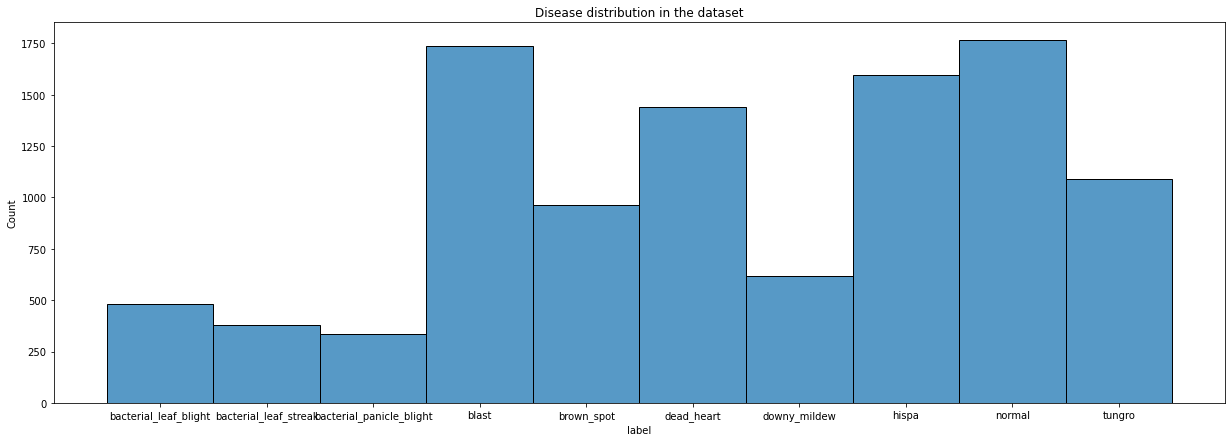

In [11]:
fig,axes = plt.subplots(1,1,figsize=(21,7))
sns.histplot(data,x='label',bins=10,ax=axes)
plt.title('Disease distribution in the dataset')
plt.show()

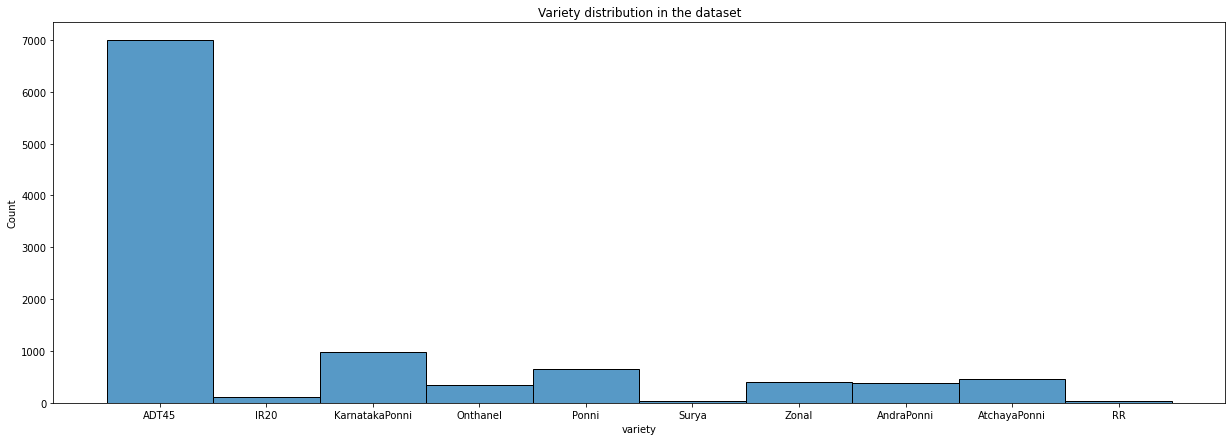

In [12]:
fig,axes = plt.subplots(1,1,figsize=(21,7))
sns.histplot(data,x='variety',ax=axes)
plt.title('Variety distribution in the dataset')
plt.show()

In [13]:
data[data['label']!='normal']['variety'].value_counts()


ADT45             5535
KarnatakaPonni     988
AtchayaPonni       461
Zonal              399
AndraPonni         377
Ponni              376
Onthanel           343
IR20               114
Surya               32
RR                  18
Name: variety, dtype: int64

In [14]:
images = ['../input/paddy-disease-classification/train_images/hispa/106590.jpg',\
          '../input/paddy-disease-classification/train_images/tungro/109629.jpg',\
          '../input/paddy-disease-classification/train_images/bacterial_leaf_blight/109372.jpg',\
          '../input/paddy-disease-classification/train_images/downy_mildew/102350.jpg',\
          '../input/paddy-disease-classification/train_images/blast/110243.jpg',\
          '../input/paddy-disease-classification/train_images/bacterial_leaf_streak/101104.jpg',\
          '../input/paddy-disease-classification/train_images/normal/109760.jpg',\
          '../input/paddy-disease-classification/train_images/brown_spot/104675.jpg',\
          '../input/paddy-disease-classification/train_images/dead_heart/105159.jpg',\
          '../input/paddy-disease-classification/train_images/bacterial_panicle_blight/101351.jpg',\
         ]
diseases = ['hispa','tungro','bacterial_leaf_blight','downy_mildew','blast','bacterial_leaf_streak',\
           'normal','brown_spot','dead_heart','bacterial_panicle_blight']
diseases = [disease +' disease' for disease in diseases]

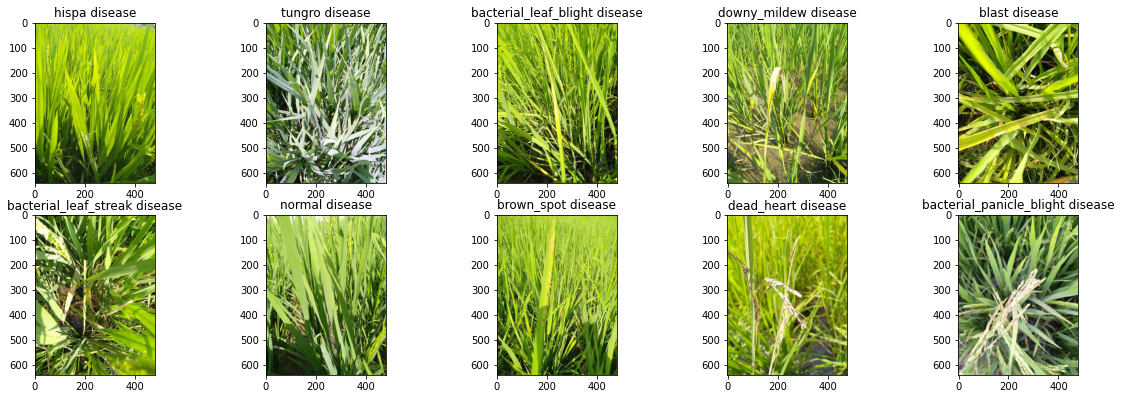

In [15]:
plt.figure(figsize=(20,10))
columns = 5
for i, image_loc in enumerate(images):
    plt.subplot(len(images)//columns + 1, columns, i + 1)
    image=plt.imread(image_loc)
    plt.title(diseases[i])
    plt.imshow(image)

In [16]:
# use data augmentation to improve accuracy and prevent overfitting
aug_gens = ImageDataGenerator(
    rescale=1.0/255.0,
    featurewise_center=False,  
    samplewise_center=False, 
    featurewise_std_normalization=False,  
    samplewise_std_normalization=False,  
    zca_whitening=False,  
    validation_split=0.1,
    rotation_range=10,
    shear_range=0.25,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
)

In [17]:
train_loc = '../input/paddy-disease-classification/train_images/'
train_data = aug_gens.flow_from_directory(
    train_loc,
    subset="training",
    seed=2,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode="categorical")


Found 9371 images belonging to 10 classes.


In [18]:
valid_data = aug_gens.flow_from_directory(
    train_loc,
    subset="validation",
    seed=2,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    class_mode="categorical")

Found 1036 images belonging to 10 classes.


In [19]:
test_loc = '../input/paddy-disease-classification/test_images'
test_data = ImageDataGenerator(rescale=1.0/255).flow_from_directory(    
    directory=test_loc,
    target_size=(img_rows, img_cols),
    batch_size=batch_size,
    classes=['.'],
    shuffle=False,
)

Found 3469 images belonging to 1 classes.


In [20]:
print(train_data.class_indices)
print(len(train_data.class_indices))

{'bacterial_leaf_blight': 0, 'bacterial_leaf_streak': 1, 'bacterial_panicle_blight': 2, 'blast': 3, 'brown_spot': 4, 'dead_heart': 5, 'downy_mildew': 6, 'hispa': 7, 'normal': 8, 'tungro': 9}
10


**Activation function** - LeakyReLu

In [21]:
leakyrelu = tf.keras.layers.LeakyReLU(alpha=0.01)

* **Swish**<br>
  **Mathematical formula**<br>
    Y = X * sigmoid(X) = X /(1 + e^-X)

[-2.68280104e-03 -6.37735836e-03 -1.48357389e-02 -3.34642546e-02
 -7.19448398e-02 -1.42277620e-01 -2.38405844e-01 -2.68941421e-01
  0.00000000e+00  7.31058579e-01  1.76159416e+00  2.85772238e+00
  3.92805516e+00]


<function matplotlib.pyplot.show(close=None, block=None)>

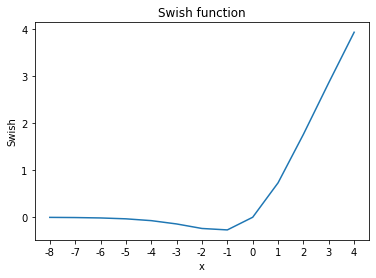

In [22]:
x = np.arange(-8,5)
swish = x/(1+np.exp(-x))
print(swish)
pd.Series(swish).plot(kind='line')
plt.title('Swish function')
plt.xticks(range(len(x)),x)
plt.ylabel('Swish')
plt.xlabel('x')
plt.show

<h2 class="list-group-item list-group-item-action active" style='color:#007500 ; background:white' >Baseline model </h2>

In [23]:
input_layer = Input((img_rows,img_cols,3))
conv2d_1_1 = Conv2D(filters=16, kernel_size=3,strides =(1,1), activation='relu', padding="same", name ="conv2d_branch1")(input_layer)
maxpool = MaxPool2D(pool_size=[2,2])(conv2d_1_1)

conv2d_1_2 = Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding="same")(maxpool)
maxpool = MaxPool2D(pool_size=[2,2])(conv2d_1_2)

conv2d_1_3 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same")(maxpool)
maxpool = MaxPool2D(pool_size=[2,2])(conv2d_1_3)

conv2d_1_4 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding="same")(maxpool)
maxpool = MaxPool2D(pool_size=[2,2])(conv2d_1_4)

flatten = Flatten()(maxpool)
dense_1 = Dense(1024, activation='swish')(flatten)
dense_2 = Dense(128, activation='swish')(dense_1)

output_dense = Dense(num_class, activation="softmax")(dense_2)

model = Model(inputs=[input_layer], outputs=[output_dense])

<h2 class="list-group-item list-group-item-action active" style='color:#007500 ; background:white' >Resnet Architecture</h2>

In [24]:
def conv_layer(input,filter=64,strides=2):
    conv_1 = Conv2D(filter, kernel_size=3,strides=strides ,padding='same',activation = 'relu',kernel_initializer = 'glorot_normal')(input)
    conv_2 = Conv2D(filter, kernel_size=3,strides=strides , padding='same',kernel_initializer = 'glorot_normal')(conv_1)
    bn     = BatchNormalization(axis=3)(conv_2)
    act    = Activation('relu')(bn)
    pool   = MaxPool2D((2,2))(act)
    return pool

In [25]:
def build_model():
    input  = Input((img_rows,img_cols,3))
    conv_1 = conv_layer(input,filter=16,strides=1)
    conv_2 = conv_layer(conv_1,filter=16,strides=1)
    pool = MaxPool2D((2,2))(conv_1)
    merge1 = concatenate([pool,conv_2], axis = 3)
    #pool = MaxPool2D((2,2))(merge1)
    
    conv_3 = conv_layer(merge1,filter=32,strides=1)
    conv_4 = conv_layer(conv_3,filter=32,strides=1)
    pool = MaxPool2D((2,2))(conv_3)
    merge2 = concatenate([pool,conv_4], axis = 3)
    #pool = MaxPool2D((2,2))(merge2)
    
    conv_5 = Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding="same") (merge2)
    pool = MaxPool2D(pool_size=[2,2])(conv_5)
    
    conv_6 = Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding="same")(pool)
    pool = MaxPool2D(pool_size=[2,2])(conv_6)
    
    dense  = Flatten()(pool)
    dense  = Dense(128,activation='relu')(dense)
    drop   = Dropout(0.4)(dense)
    dense  = Dense(64,activation='relu')(dense)
    output = Dense(num_class, activation='softmax')(drop)    

    model = Model(inputs=[input],outputs = [output])
    return model

model = build_model()

In [26]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 256, 256, 16) 2320        conv2d_3[0][0]                   
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d_4[0][0]                   
____________________________________________________________________________________________

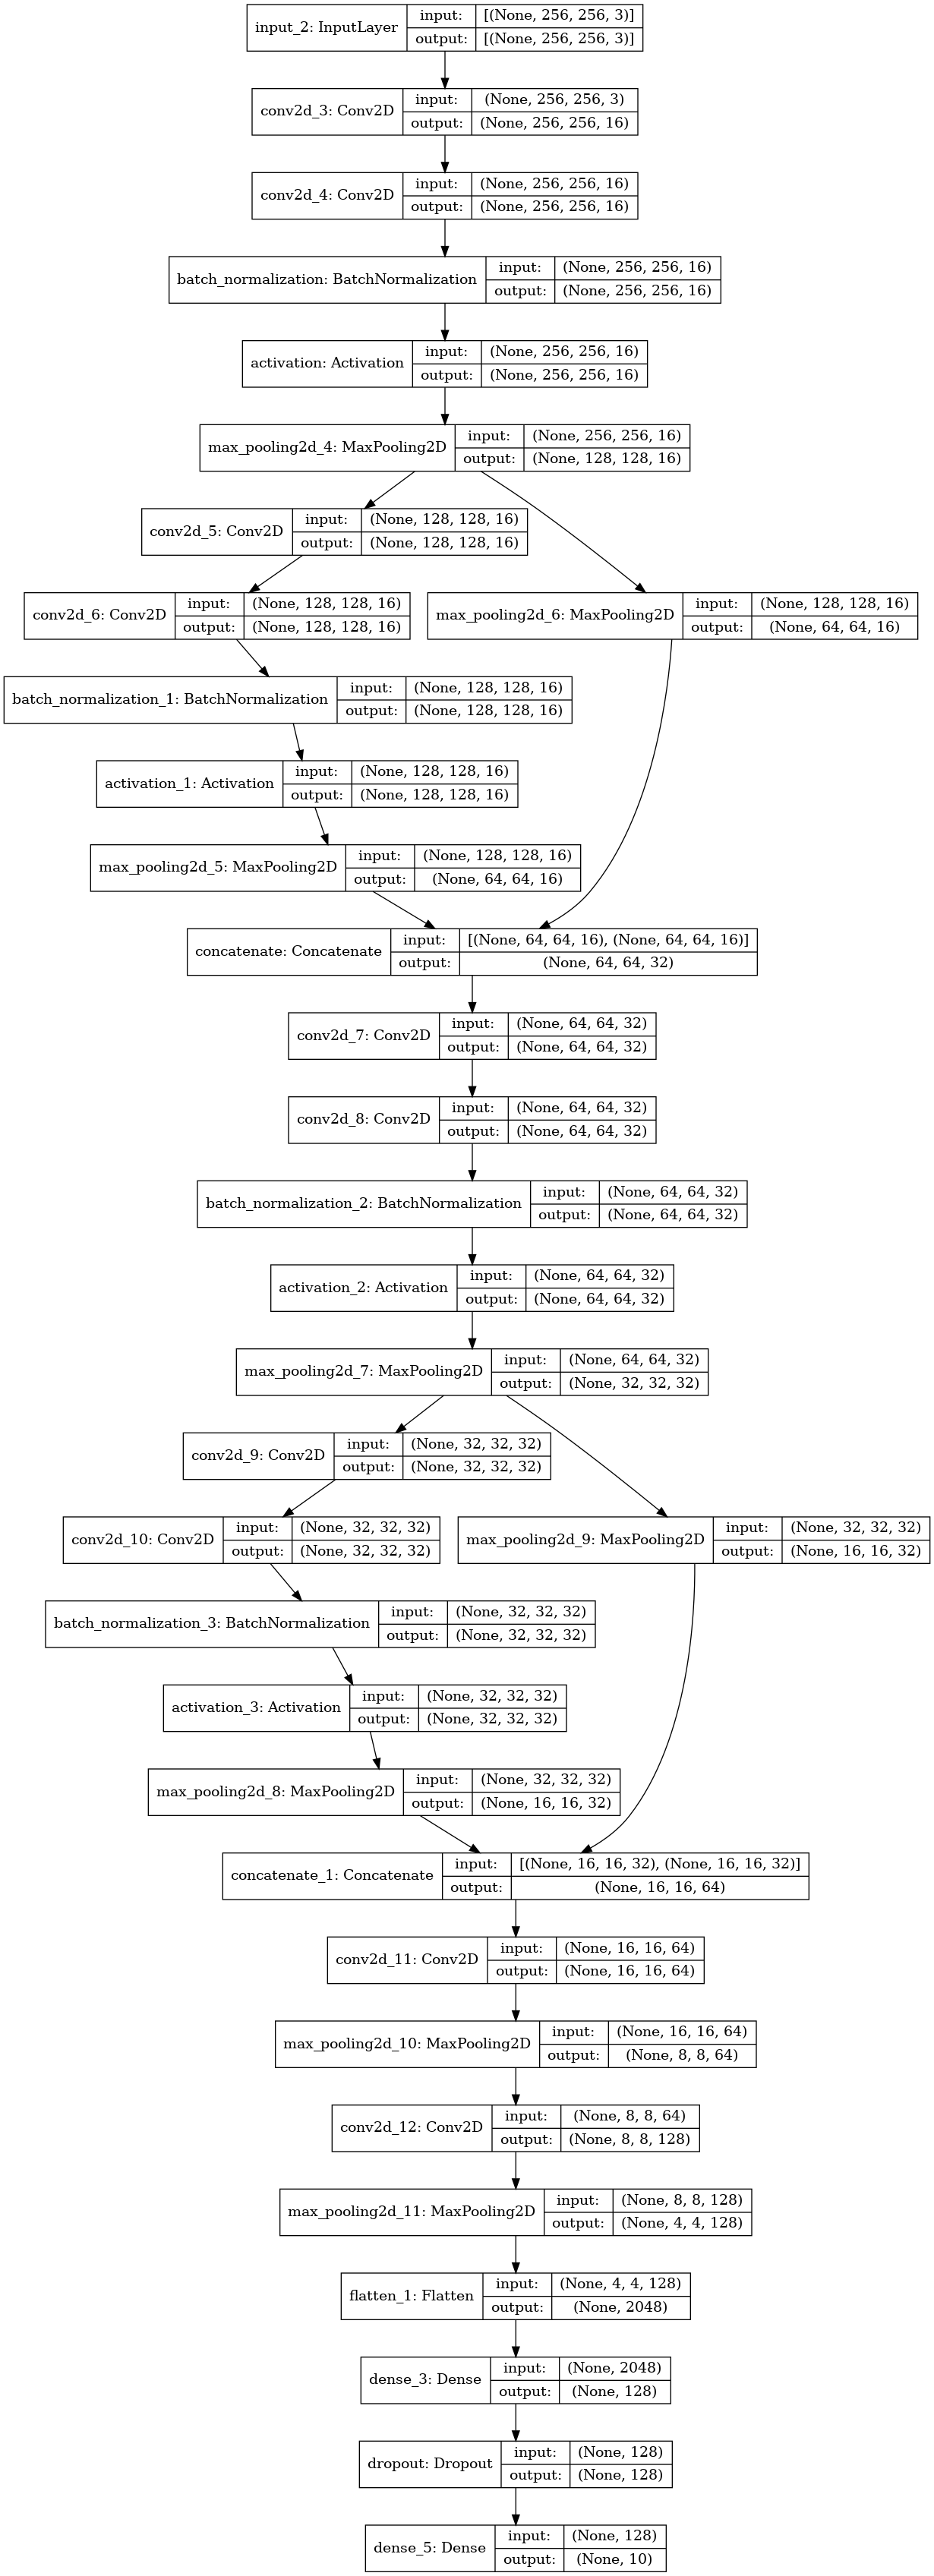

In [27]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)
Image("model.png")

In [28]:
EPOCH = 10

lr_reduction = ReduceLROnPlateau(monitor='val_loss',patience=8, verbose=1,  factor=0.4, min_lr=0.0005)

early_stop = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=8, mode='auto', restore_best_weights=True, verbose=1)

checkpoint = ModelCheckpoint('model.hdf5', monitor='val_loss', save_best_only=True,verbose=1)

In [29]:
model.compile(optimizer= 'adam',loss=tf.losses.CategoricalCrossentropy(),metrics=['accuracy'])
model_fit = model.fit(train_data, epochs=EPOCH ,batch_size = batch_size ,validation_data=valid_data, verbose =1,callbacks=[checkpoint,lr_reduction])

Epoch 1/10
147/147 [==============================] - 250s 2s/step - loss: 2.0741 - accuracy: 0.2611 - val_loss: 2.3786 - val_accuracy: 0.1535

Epoch 00001: val_loss improved from inf to 2.37859, saving model to model.hdf5
Epoch 2/10
147/147 [==============================] - 199s 1s/step - loss: 1.7646 - accuracy: 0.3934 - val_loss: 3.1535 - val_accuracy: 0.1535

Epoch 00002: val_loss did not improve from 2.37859
Epoch 3/10
147/147 [==============================] - 199s 1s/step - loss: 1.5880 - accuracy: 0.4520 - val_loss: 2.1746 - val_accuracy: 0.2925

Epoch 00003: val_loss improved from 2.37859 to 2.17460, saving model to model.hdf5
Epoch 4/10
147/147 [==============================] - 198s 1s/step - loss: 1.4236 - accuracy: 0.5142 - val_loss: 1.9485 - val_accuracy: 0.3533

Epoch 00004: val_loss improved from 2.17460 to 1.94849, saving model to model.hdf5
Epoch 5/10
147/147 [==============================] - 199s 1s/step - loss: 1.3063 - accuracy: 0.5571 - val_loss: 1.6438 - val_ac

In [30]:
model.load_weights('model.hdf5')

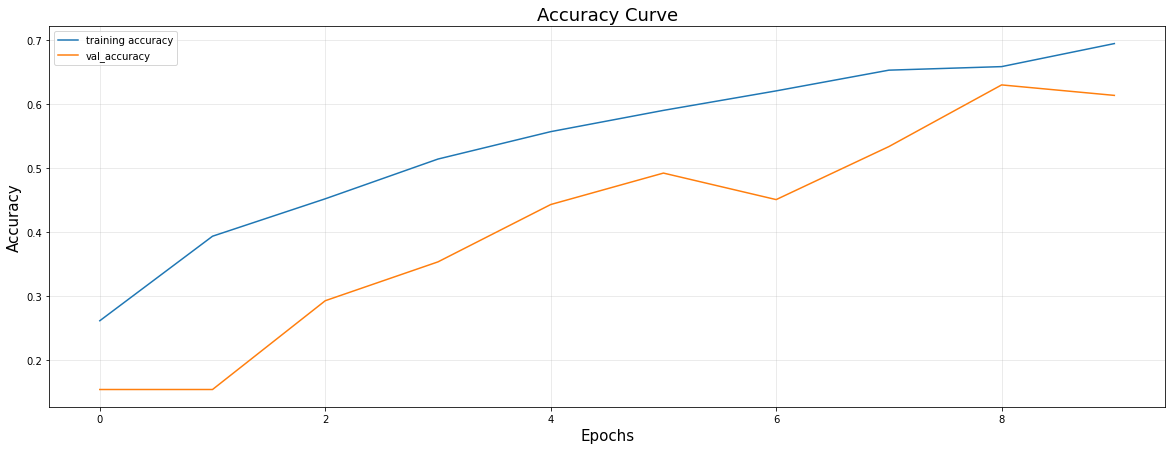

In [31]:
f = plt.figure(figsize=(20,7))

# For Accuracy
plt.plot(model_fit.epoch,model_fit.history['accuracy'],label = "training accuracy") # Accuracy curve for training set
plt.plot(model_fit.epoch,model_fit.history['val_accuracy'],label = "val_accuracy") # Accuracy curve for validation set

plt.title("Accuracy Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Accuracy",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

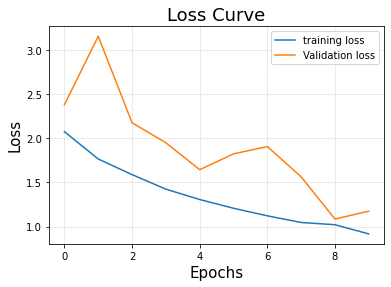

In [32]:
plt.plot(model_fit.epoch,model_fit.history['loss'],label="training loss") # Loss curve for training set
plt.plot(model_fit.epoch,model_fit.history['val_loss'],label="Validation loss") # Loss curve for validation set

plt.title("Loss Curve",fontsize=18)
plt.xlabel("Epochs",fontsize=15)
plt.ylabel("Loss",fontsize=15)
plt.grid(alpha=0.3)
plt.legend()

plt.show()

In [33]:
!mkdir -p saved_model
model.save('saved_model/my_model.json')

In [34]:
#load_model = tf.keras.models.load_model('saved_model/my_model.json')
load_model = model

<h2 class="list-group-item list-group-item-action active" style='color:#007500 ; background:white'>Evaluate</h2> <a id=6></a>

In [35]:
evaluate_test = model.evaluate(test_data, verbose=1)
print("\nAccuracy =", "{:.7f}%".format(evaluate_test[1]*100))
print("Loss     =" ,"{:.9f}".format(evaluate_test[0]))

55/55 [==============================] - 42s 763ms/step - loss: 63.5873 - accuracy: 0.0118

Accuracy = 1.1818968%
Loss     = 63.587310791


In [36]:
y_predict_max = np.argmax(model.predict(test_data),axis=1)

<h3 class="list-group-item list-group-item-action active" style='color:#007500 ; background:white'>Submission</h3>

In [37]:
inverse_map = {v:k for k,v in train_data.class_indices.items()}

predictions = [inverse_map[k] for k in y_predict_max]

In [38]:
files=test_data.filenames

results=pd.DataFrame({"image_id":files,
                      "label":predictions})
results.image_id = results.image_id.str.replace('./', '')
results.to_csv("submission.csv",index=False)
results.head()

,image_id,label
0,200001.jpg,blast
1,200002.jpg,blast
2,200003.jpg,hispa
3,200004.jpg,blast
4,200005.jpg,blast
